In [ ]:
import time, datetime
import requests 
import pickle as pkl 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support


In [9]:
def query_prom(query, startTime, endTime, PROMETHEUS = 'http://20.71.55.156:9090/', debug=False):
    response = requests.get(PROMETHEUS + '/api/v1/query_range',
      params={'query': query,
              'start': startTime,
              'end': endTime,
              'step': '15s'})
    if debug:
        print(response.json())
    results = response.json()['data']['result']
    return results

In [10]:
from prometheus_api_client import PrometheusConnect
prom = PrometheusConnect(url ="http://20.71.55.156:9090", disable_ssl=True)

# Get the list of all the metrics that the Prometheus host scrapes
metrics = prom.all_metrics()
# import pprint
# pprint.pprint(metrics)


In [11]:
startTime = 1619692800
endTime = 1619696520

startTime = 1620598279
endTime = 1620648679

startTime = 1621335960
endTime = 1621343220


In [12]:
caliper_txn_failure = list(map(float,np.array(query_prom('caliper_txn_failure', startTime, endTime)[0]['values'])[:,1]))


In [13]:
def caliper_df(label, startTime=startTime, endTime=endTime):
    label_data = query_prom(label, startTime, endTime, debug=False)[0]
    time = list(map(int, np.array(label_data['values'])[:,0]))
    value_t = list(map(float, np.array(label_data['values'])[:,1]))
    # transfer time from timestamp to datetime
    time_ax = []
    for each in time:
        time_ax.append(datetime.datetime.fromtimestamp(each))
    label = [0]
    for i in range(1,len(value_t)):
        if value_t[i]-value_t[i-1] != 0:
            label.append(1)
        else:
            label.append(0)
    return pd.DataFrame({'time': time_ax,'label': label})


# Caliper data for label
txn_failure = 'caliper_txn_failure'
label_data=caliper_df(txn_failure)

In [16]:
def query_data(metric):
    query = 'irate('+metric+'{device="sdb",instance="nodeexporter1",job="nodeexporter"}[5m])'
    try:
        result = query_prom(query, startTime, endTime)[0]
        value = list(map(float, np.array(result['values'])[:,1]))
        label_data[metric] = value
        return value
    except:
        pass

In [17]:
for metric in tqdm(metrics):
    query_data(metric)
# print(label_data.head())

<p style="color:red;">Looks like not all metrics hold data since query_prom(query, startTime, endTime)[0] is empty</p>

In [62]:
caliper_txn_failure = list(map(float,np.array(query_prom('caliper_txn_failure', startTime, endTime)[0]['values'])[:,1]))
label_data["caliper_txn_falure"] = caliper_txn_failure
label_data.head()

,time,label,node_disk_discard_time_seconds_total,node_disk_discarded_sectors_total,node_disk_discards_completed_total,node_disk_discards_merged_total,node_disk_io_now,node_disk_io_time_seconds_total,node_disk_io_time_weighted_seconds_total,node_disk_read_bytes_total,node_disk_read_time_seconds_total,node_disk_reads_completed_total,node_disk_reads_merged_total,node_disk_write_time_seconds_total,node_disk_writes_completed_total,node_disk_writes_merged_total,node_disk_written_bytes_total,caliper_txn_falure
0,2021-05-18 13:06:00,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2,12506.0
1,2021-05-18 13:06:15,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2,12506.0
2,2021-05-18 13:06:30,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2,12506.0
3,2021-05-18 13:06:45,1,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2,0.0
4,2021-05-18 13:07:00,0,0.0,0.0,0.0,0.0,0.0,0.0008,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,819.2,0.0


# Correlation
<p style="color:red;">Correlate with caliper txn falure or boolean labels?</p>

In [90]:
labels_to_correlate = label_data.drop(['label', 'caliper_txn_falure', 'time'], axis=1)

In [94]:
from scipy import stats
import pprint

correlation_txn_falure = {}
for label in labels_to_correlate.columns:
    r,p = stats.pearsonr(labels_to_correlate[label], label_data.caliper_txn_falure)
    correlation_txn_falure[label] = (p,r)


/home/ole/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [106]:
pd.DataFrame.from_dict(correlation_txn_falure, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

,r,p-value
node_disk_io_time_weighted_seconds_total,0.185964,-0.060158
node_disk_discard_time_seconds_total,0.088550,-0.077417
node_disk_discarded_sectors_total,0.084795,-0.078343
node_disk_discards_completed_total,0.082269,-0.078984
node_disk_io_time_seconds_total,0.038532,-0.093990
node_disk_writes_merged_total,0.026181,-0.100967
node_disk_write_time_seconds_total,0.002296,-0.138141
node_disk_writes_completed_total,0.000336,-0.162155
node_disk_written_bytes_total,0.000299,-0.163521
node_disk_discards_merged_total,NaN,NaN


In [107]:
from scipy import stats
import pprint

correlation_txn_falure_bool = {}
for label in labels_to_correlate.columns:
    r,p = stats.pointbiserialr(labels_to_correlate[label], label_data.label)
    correlation_txn_falure_bool[label] = (p,r)
pd.DataFrame.from_dict(correlation_txn_falure_bool, orient='index').rename(columns={0:'r', 1:'p-value'}).sort_values('r', ascending=False)

/home/ole/.local/lib/python3.6/site-packages/scipy/stats/stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


,r,p-value
node_disk_writes_merged_total,0.825554,-0.010034
node_disk_write_time_seconds_total,0.794688,-0.011846
node_disk_written_bytes_total,0.686442,0.018376
node_disk_writes_completed_total,0.678714,0.018856
node_disk_io_time_seconds_total,0.634902,-0.021615
node_disk_io_time_weighted_seconds_total,0.444026,-0.034835
node_disk_discard_time_seconds_total,0.324519,-0.044829
node_disk_discarded_sectors_total,0.318763,-0.045365
node_disk_discards_completed_total,0.314815,-0.045737
node_disk_discards_merged_total,NaN,NaN


<p style="color:red;">2 methods to calculate correlation, dont know which method is best for the data</p>

<AxesSubplot:>

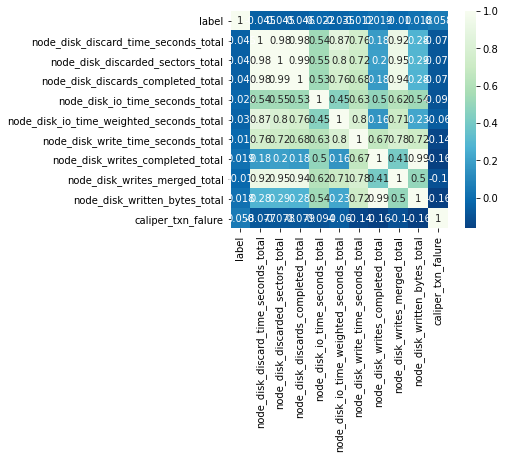

In [121]:
import seaborn as sns
correlations = label_data.corr().dropna(axis=1, how='all').T.dropna(axis=1, how='all').T
# heatmap
plt.figure(figsize=(6,4))
sns.heatmap(correlations, cmap='GnBu_r', square=True, annot=True)
#plt.savefig('xx.png')